In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import ast

# **House Price Prediction for Airbnb Listings**

## **Introduction**
This project aims to build a predictive model for Airbnb listing prices. The objective is to use historical Airbnb data 
from different quarters and cities to develop a model that accurately estimates listing prices. 

The steps involved in this project include:
- **Data Preprocessing**: Cleaning and transforming the dataset to extract meaningful features.
- **Feature Engineering**: Selecting relevant variables and handling categorical and numerical features.
- **Model Building**: Training multiple predictive models (OLS, LASSO, Random Forest, Gradient Boosting, and XGBoost).
- **Model Evaluation**: Comparing model performance based on RMSE, R², and computation time.
- **Feature Importance Analysis**: Identifying the most influential variables affecting price predictions.
- **Validation on New Data**: Testing model performance on a later dataset and a different city.



In [2]:
# Correct raw file URLs
data_url_istanbul_q1 = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/istanbul-q1.csv"
data_url_istanbul_q3 = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/istanbul-q3.csv"
data_url_athens = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/athens.csv"

istanbul_q1 = pd.read_csv(data_url_istanbul_q1)
istanbul_q3 = pd.read_csv(data_url_istanbul_q3)
athens = pd.read_csv(data_url_athens)

df_list = [istanbul_q1, istanbul_q3, athens]


In [3]:
print(f"Istanbul Q1 size: {istanbul_q1.shape}")
print(f"Istanbul Q3 size: {istanbul_q3.shape}")
print(f"Athens size: {athens.shape}")

Istanbul Q1 size: (34446, 18)
Istanbul Q3 size: (29101, 18)
Athens size: (14642, 75)


In [2]:
istanbul_df = pd.read_csv('/Users/amh/Downloads/istanbul_1.csv')

## **Data Preprocessing and Feature Engineering**

Before training our predictive models, we perform the following preprocessing steps:

1. **Handling Missing Values**: Some attributes such as amenities and reviews may contain missing data. We use appropriate imputation techniques.
2. **Date Conversion**: If applicable, date fields are converted to datetime format to extract meaningful time-based features.
3. **Feature Selection**:
   - **Numerical Features**: Price, number of bedrooms, number of reviews, etc.
   - **Categorical Features**: Neighborhood, property type, room type, etc.
   - **Amenities**: Extracting presence of popular amenities (e.g., WiFi, kitchen, pool).
4. **Encoding**:
   - **One-hot encoding** is applied to categorical features.
   - **Standardization** is used for numerical variables to improve model convergence.


In [3]:
print(istanbul_df['amenities'].unique())

['["Freezer", "Luggage dropoff allowed", "Bread maker", "Mosquito net", "Baking sheet", "Dishes and silverware", "Cooking basics", "Paid parking lot off premises", "Game console: PS4", "Refrigerator", "Air conditioning", "Bathtub", "Extra pillows and blankets", "Exercise equipment: free weights", "Dedicated workspace", "Oven", "Pocket wifi", "Wine glasses", "Wifi", "Outdoor playground", "Coffee maker: espresso machine, pour-over coffee", "Private entrance", "Bed linens", "HDTV with standard cable, Disney+, Netflix, premium cable", "Children\'s playroom", "Dishwasher", "Dryer", "Backyard", "Free street parking", "Drying rack for clothing", "Blender", "Heating", "Hangers", "Hot tub", "Hair dryer", "Building staff", "Ethernet connection", "Sound system", "Books and reading material", "Toaster", "Arcade games", "Kitchen", "Public or shared beach access", "Free parking on premises", "Microwave", "Hot water", "Self check-in", "Washer", "Iron", "Hot water kettle", "Dining table", "Room-darken

In [4]:
# Define amenity categories
amenity_categories = {
    "comfort": ["air conditioning", "heating", "extra pillows", "room-darkening shades", "hair dryer", "hot water", "mosquito net"],
    "kitchen": ["kitchen", "stove", "oven", "microwave", "dishwasher", "refrigerator", "freezer", "coffee maker", "cooking basics",
                "bread maker", "baking sheet", "toaster", "blender", "dishes and silverware", "barbecue utensils", "gas stove", "dining table"],
    "laundry": ["washer", "dryer", "drying rack", "ironing", "clothing storage", "laundry"],
    "entertainment": ["tv", "hdtv", "netflix", "cable", "sound system", "books", "reading material", "game console", "arcade", "piano"],
    "family": ["children", "crib", "high chair", "playroom", "books and toys", "bathtub"],
    "outdoors": ["terrace", "balcony", "backyard", "beach access", "patio", "barbecue", "fire pit", "garden"],
    "wellness": ["hot tub", "sauna", "gym", "exercise equipment"],
    "work": ["dedicated workspace", "desk", "ethernet", "monitor", "work"],
    "parking": ["free parking", "paid parking", "street parking", "parking lot", "ev charger"],
    "safety": ["smoke alarm", "carbon monoxide alarm", "first aid kit", "fire extinguisher", "safe", "security cameras"],
    "luxury": ["fireplace", "wine glasses", "espresso", "premium cable", "smart lock", "bidet", "pool"],
    "cleaning": ["cleaning", "cleaning products", "shampoo", "conditioner", "essentials"],
    "connectivity": ["wifi", "pocket wifi", "internet"]
}

# Classify grouped amenities into binary columns
def classify_amenities_column(df):
    for cat in amenity_categories:
        df[f"amenity_{cat}"] = 0
    for idx, row in df.iterrows():
        try:
            amenities = ast.literal_eval(row['amenities'].lower())
        except:
            continue
        for cat, keywords in amenity_categories.items():
            if any(any(k in a for k in keywords) for a in amenities):
                df.at[idx, f"amenity_{cat}"] = 1
    return df

# Classify high-level description features
def categorize_description_features(df):
    desc = df['description'].fillna("").str.lower()
    df['view_type'] = desc.apply(lambda t: "sea_view" if "sea view" in t or "bosphorus" in t else
                                              "city_view" if "city view" in t or "panoramic" in t else
                                              "garden_view" if "garden" in t or "greenery" in t else "no_view")
    df['location_type'] = desc.apply(lambda t: "near_metro" if any(x in t for x in ["metro", "subway", "station"]) else
                                                  "near_taksim" if any(x in t for x in ["taksim", "kabatas"]) else
                                                  "quiet_area" if any(x in t for x in ["quiet", "peaceful", "no traffic"]) else "unspecified_location")
    df['amenity_type'] = desc.apply(lambda t: "terrace" if "terrace" in t else
                                               "balcony" if "balcony" in t else
                                               "kitchen" if any(x in t for x in ["kitchen", "stove", "oven"]) else "standard")
    df['suitability'] = desc.apply(lambda t: "work_friendly" if any(x in t for x in ["remote work", "working from home", "staycation"]) else
                                              "family" if any(x in t for x in ["family", "group", "kids"]) else
                                              "female_only" if any(x in t for x in ["female only", "female guests"]) else "generic")
    df['attraction_tag'] = desc.apply(lambda t: "seaside" if any(x in t for x in ["seaside", "shore", "coast"]) else
                                                 "food_drink" if any(x in t for x in ["restaurant", "bar", "cafe"]) else
                                                 "historic" if any(x in t for x in ["historical", "old town"]) else "none")
    return df

# Reduce cardinality of description features
def reduce_cardinality(df, col, top_n=3):
    top = df[col].value_counts().nlargest(top_n).index
    df[f'{col}_reduced'] = df[col].where(df[col].isin(top), 'other')
    return df

# Apply everything
desc_cats = ['view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag']
istanbul_df = classify_amenities_column(istanbul_df)
istanbul_df = categorize_description_features(istanbul_df)
for col in desc_cats:
    istanbul_df = reduce_cardinality(istanbul_df, col, top_n=4)


In [5]:
columns_to_drop = [
    # IDs & URLs
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url',
    # Host info
    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_thumbnail_url', 'host_picture_url', 'host_verifications',
    'host_is_superhost', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_has_profile_pic', 'host_identity_verified',
    # Location text
    'neighbourhood', 'neighbourhood_overview', 'neighbourhood_group_cleansed',
    # Redundant
    'description', 'name', 'bathrooms_text', 'amenities',
    # Calendar & review timing
    'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    # Counts
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month',
    # Redundant review score breakdowns (you can keep 1–2)
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    # Raw categorical versions of description variables
    'view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag',
    # Other
    'license', 'instant_bookable'
    # amenity categories
     'amenity_comfort', 'amenity_kitchen', 'amenity_laundry', 'amenity_entertainment',
    'amenity_family', 'amenity_outdoors', 'amenity_wellness', 'amenity_work',   
    'amenity_parking', 'amenity_safety', 'amenity_luxury', 'amenity_cleaning', 'amenity_comfort',
    'amenity_connectivity'
    # neighbourhoods
        'neighborhood_overview', 'neighbourhood_cleansed', 'property_type', 'neighborhood_overview',
    #Availability
    'has_availability', 'availability_60', 'availability_90'
]
istanbul_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [6]:
from sklearn.cluster import KMeans

# Create location cluster
def add_location_cluster(df, n_clusters=10):
    coords = df[['latitude', 'longitude']].dropna()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['location_cluster'] = kmeans.fit_predict(coords)
    return df
istanbul_df = add_location_cluster(istanbul_df)
# Drop original latitude and longitude columns
istanbul_df.drop(columns=['latitude', 'longitude'], inplace=True, errors='ignore')


In [27]:
# Define categorical columns
categorical_cols = ['room_type', 'view_type_reduced', 'location_type_reduced',
                    'amenity_type_reduced', 'suitability_reduced', 'attraction_tag_reduced']

# Define numerical columns (exclude price and categoricals)
drop_cols = ['price']
numerical_cols = [col for col in istanbul_df.columns if col not in categorical_cols + drop_cols]

# Clean target variable
istanbul_df['price'] = istanbul_df['price'].replace(r'[\$,]', '', regex=True).astype(float)
istanbul_df = istanbul_df.dropna(subset=['price'])

# Drop any rows with NaNs in selected features
istanbul_df = istanbul_df.dropna(subset=categorical_cols + numerical_cols)

# Define X and y
X_raw = istanbul_df[categorical_cols + numerical_cols]
y = istanbul_df['price'].reset_index(drop=True)

# Set up encoder
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough'
)

# Apply transformation
X_encoded = preprocessor.fit_transform(X_raw)

# Get correct column names
encoded_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
final_col_names = list(encoded_col_names) + numerical_cols

# Create final DataFrame
istanbul_encoded_df= pd.DataFrame(X_encoded, columns=final_col_names)

# Ensure numeric and aligned
istanbul_encoded_df = istanbul_encoded_df.apply(pd.to_numeric, errors='coerce')
istanbul_encoded_df = istanbul_encoded_df.fillna(0)
istanbul_encoded_df = istanbul_encoded_df.reset_index(drop=True)
y = y.loc[istanbul_encoded_df.index]

# Final check
print("✅ Final shape:", istanbul_encoded_df.shape, y.shape)
print("Any NaNs?", istanbul_encoded_df.isna().any().any(), y.isna().any())

✅ Final shape: (19477, 38) (19477,)
Any NaNs? False False


In [19]:
print(istanbul_encoded_df.dtypes.value_counts())


object    38
Name: count, dtype: int64


In [14]:
istanbul_df.columns

Index(['neighborhood_overview', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'view_type_reduced', 'location_type_reduced', 'amenity_type_reduced',
       'suitability_reduced', 'attraction_tag_reduced', 'location_cluster'],
      dtype='object')

In [6]:
# Apply preprocessing
df_istanbul_q1 = preprocess_data(df_list[0])
df_istanbul_q3 = preprocess_data(df_list[1])
df_athens = preprocess_data(df_list[2])

In [31]:
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(istanbul_encoded_df, y, test_size=0.2, random_state=42)

# 2. Model evaluation helper
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_dict):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds) ** 0.5  # <-- Manual RMSE
    results_dict[name] = {"RMSE": round(rmse, 2), "Time (s)": round(time.time() - start, 2)}



## **Predictive Modeling**

We train five different models to compare performance:
1. **Ordinary Least Squares (OLS)**: A simple linear regression model.
2. **LASSO Regression**: A regularized linear model that prevents overfitting.
3. **Random Forest**: A tree-based ensemble model that captures non-linear relationships.
4. **Gradient Boosting (XGBoost)**: A powerful boosting algorithm that iteratively corrects errors.
5. **Another Boosting Model (LightGBM or CatBoost)**: An alternative boosting approach for comparison.

The models are trained on the preprocessed dataset, and we evaluate their performance using RMSE, R², and computational efficiency.


In [35]:
# 3. Initialize results container
results = {}
# 4. Train and evaluate all models
evaluate_model("OLS", LinearRegression(), X_train, y_train, X_test, y_test, results)

evaluate_model("LASSO", make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42)),
               X_train, y_train, X_test, y_test, results)

evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42),
               X_train, y_train, X_test, y_test, results)

evaluate_model("XGBoost", xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
               X_train, y_train, X_test, y_test, results)

evaluate_model("Ridge", make_pipeline(StandardScaler(), RidgeCV(cv=5)),
               X_train, y_train, X_test, y_test, results)

## **Model Evaluation**

To compare model performance, we use the following metrics:
- **Root Mean Squared Error (RMSE)**: Measures the average prediction error in the same unit as the target variable.
- **R² Score**: Indicates how much variance in the target variable is explained by the model.
- **Computation Time**: Helps assess the efficiency of each model.

A summary table is generated to highlight the strengths and weaknesses of each approach.


In [36]:
# 5. Show comparison table
results_df = pd.DataFrame(results).T.sort_values("RMSE").reset_index().rename(columns={"index": "Model"})
print(results_df)

           Model      RMSE  Time (s)
0          LASSO  38387.01      0.10
1          Ridge  38406.42      0.09
2            OLS  38406.47      0.09
3  Random Forest  41348.01     16.01
4        XGBoost  57411.82      0.23


In [11]:
# Compare models
results_df = pd.DataFrame(results).T
print(results_df)

                          RMSE        R2  Time (seconds)
OLS                9269.794662 -0.055385            0.13
LASSO              9269.285453 -0.055269            1.22
RandomForest      13806.130247 -1.341071           20.58
GradientBoosting  16178.941117 -2.214925            4.32
XGBoost           10598.832487 -0.379707            0.53


## **Feature Importance Analysis**

To interpret our models, we analyze feature importance for:
- **Random Forest**: Measures how much each feature contributes to reducing uncertainty in predictions.
- **Gradient Boosting**: Identifies which features have the most impact on price predictions.

We compare the top 10 most important features across these models.


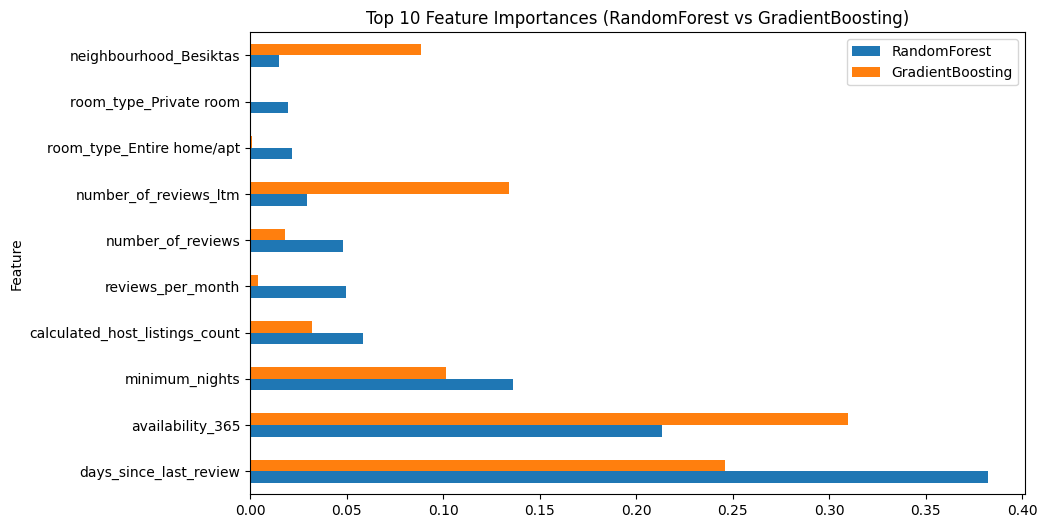

In [12]:
# Feature importance comparison
def compare_feature_importances(models, X):
    encoded_cat_features = models["RandomForest"].named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numeric_features, encoded_cat_features])

    rf_importance = models["RandomForest"].named_steps['model'].feature_importances_
    gb_importance = models["GradientBoosting"].named_steps['model'].feature_importances_

    feature_importances = pd.DataFrame({
        'Feature': all_feature_names,
        'RandomForest': rf_importance,
        'GradientBoosting': gb_importance
    })

    feature_importances.set_index("Feature", inplace=True)
    feature_importances.nlargest(10, columns=['RandomForest', 'GradientBoosting']).plot(kind='barh', figsize=(10,6))
    plt.title("Top 10 Feature Importances (RandomForest vs GradientBoosting)")
    plt.show()

compare_feature_importances(models, X_train)

## **Validation on New Data**

To ensure our models generalize well, we evaluate them on:
1. **Later Quarter Data** (Istanbul Q3) – Testing time-based robustness.
2. **Another City** (Athens) – Assessing how well models perform in a different market.

Key observations:
- A significant drop in performance may indicate overfitting to the training dataset.
- Different feature importance rankings across datasets may suggest that market dynamics vary across locations.

The results help determine the reliability of our models in real-world Airbnb pricing predictions.


In [13]:
# Preprocess validation datasets
df_istanbul_q3 = preprocess_data(istanbul_q3)  # Later quarter
df_athens = preprocess_data(athens)            # Another city

# Apply trained models to new datasets
for df, name in zip([df_istanbul_q3, df_athens], ["Istanbul Q3", "Athens"]):
    X_new = df.drop(columns=["price"])
    y_new = df["price"].fillna(df["price"].median())  # Ensure no missing values

    results_new = {}
    for model_name, model in models.items():
        y_pred_new = model.predict(X_new)
        results_new[model_name] = {
            "RMSE": np.sqrt(mean_squared_error(y_new, y_pred_new)),
            "R2": r2_score(y_new, y_pred_new)
        }

    print(f"\n📊 Results for {name}:")
    print(pd.DataFrame(results_new).T)



📊 Results for Istanbul Q3:
                          RMSE        R2
OLS               27340.423663 -0.008605
LASSO             27340.278803 -0.008594
RandomForest      33086.481663 -0.477106
GradientBoosting  29221.230547 -0.152146
XGBoost           45685.688495 -1.816247

📊 Results for Athens:
                         RMSE          R2
OLS               2801.258032  -88.039133
LASSO             2452.513371  -67.249183
RandomForest      4488.297768 -227.579887
GradientBoosting  3427.787601 -132.322208
XGBoost           4788.831749 -259.215911
